# Прогноз оттока клиентов банка
## Цель: предсказать вероятность ухода клиента на основе его характеристик.

### Импорт необходимых библиотек

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Модель Случайного Леса для задач регрессии
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix  # Метрики для оценки качества модели
import kagglehub
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


%pip install ipywidgets### Опция для показа всех колонок



In [3]:
pd.set_option('display.max_columns', None)

### 1. Загрузка датасета и обработка данных

#### Данный датасет был взят из открытого источника kaggle.
Он представляет собой анонимизированную выборку данных крупного европейского банка, работающего в трех странах

In [4]:
path = kagglehub.dataset_download("radheshyamkollipara/bank-customer-churn")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\radheshyamkollipara\bank-customer-churn\versions\1


##### Загружаю датасет

In [5]:
data = pd.read_csv('Customer-Churn-Records.csv')

##### Заранее удаляю колонки, которые не будут иметь никакого влияния на результат

In [6]:
df = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

##### Кодирую столбцы с текстом в цифры

In [7]:
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])

le_geography = LabelEncoder()
df['Geography'] = le_geography.fit_transform(df['Geography'])

le_card_type = LabelEncoder()
df['Card Type'] = le_card_type.fit_transform(df['Card Type'])

##### Изучаю датасет

In [8]:
print(df.isnull().sum())
print(df.describe())
# Вывод первых пяти строк
print(df.head())

# Делаю обратное преобразование, чтобы понять что за значения в текстовых столбцах используя функцию python enumerate
print("Кодировка Geography:", list(enumerate(le_geography.classes_)))
print("Кодировка Gender:", list(enumerate(le_gender.classes_)))
print("Кодировка Card Type:", list(enumerate(le_card_type.classes_)))

CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64
        CreditScore     Geography        Gender           Age        Tenure  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean     650.528800      0.746300      0.545700     38.921800      5.012800   
std       96.653299      0.827529      0.497932     10.487806      2.892174   
min      350.000000      0.000000      0.000000     18.000000      0.000000   
25%      584.000000      0.000000      0.000000     32.000000      3.000000   
50%      652.000000      0.000000      1.000000     37.000000      5.000000   
75%      718.000000      1.000000      1.000000     44.000000      7.00000

##### Считаю сколько клиентов уже ушло и сколько осталось используя столбец Exited. Визуализация

Exited
0    7962
1    2038
Name: count, dtype: int64


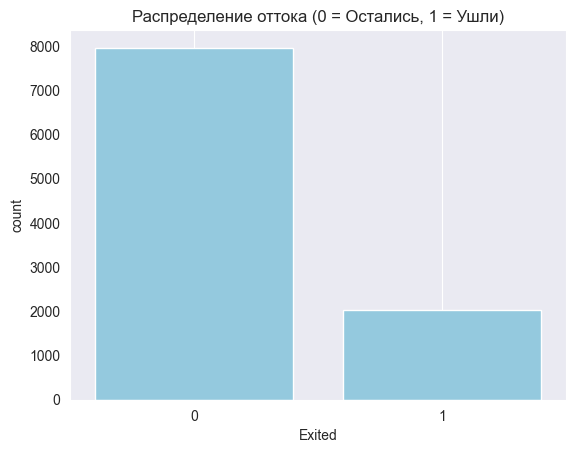

In [9]:
print(df['Exited'].value_counts())
# Визуализирую
sns.countplot(x='Exited', data=df, color='skyblue')
plt.title('Распределение оттока (0 = Остались, 1 = Ушли)')
plt.grid()
plt.savefig('Exited.png')
plt.show()

##### Рисую тепловую карту корреляции между признаками, чтобы понять что от чего зависит

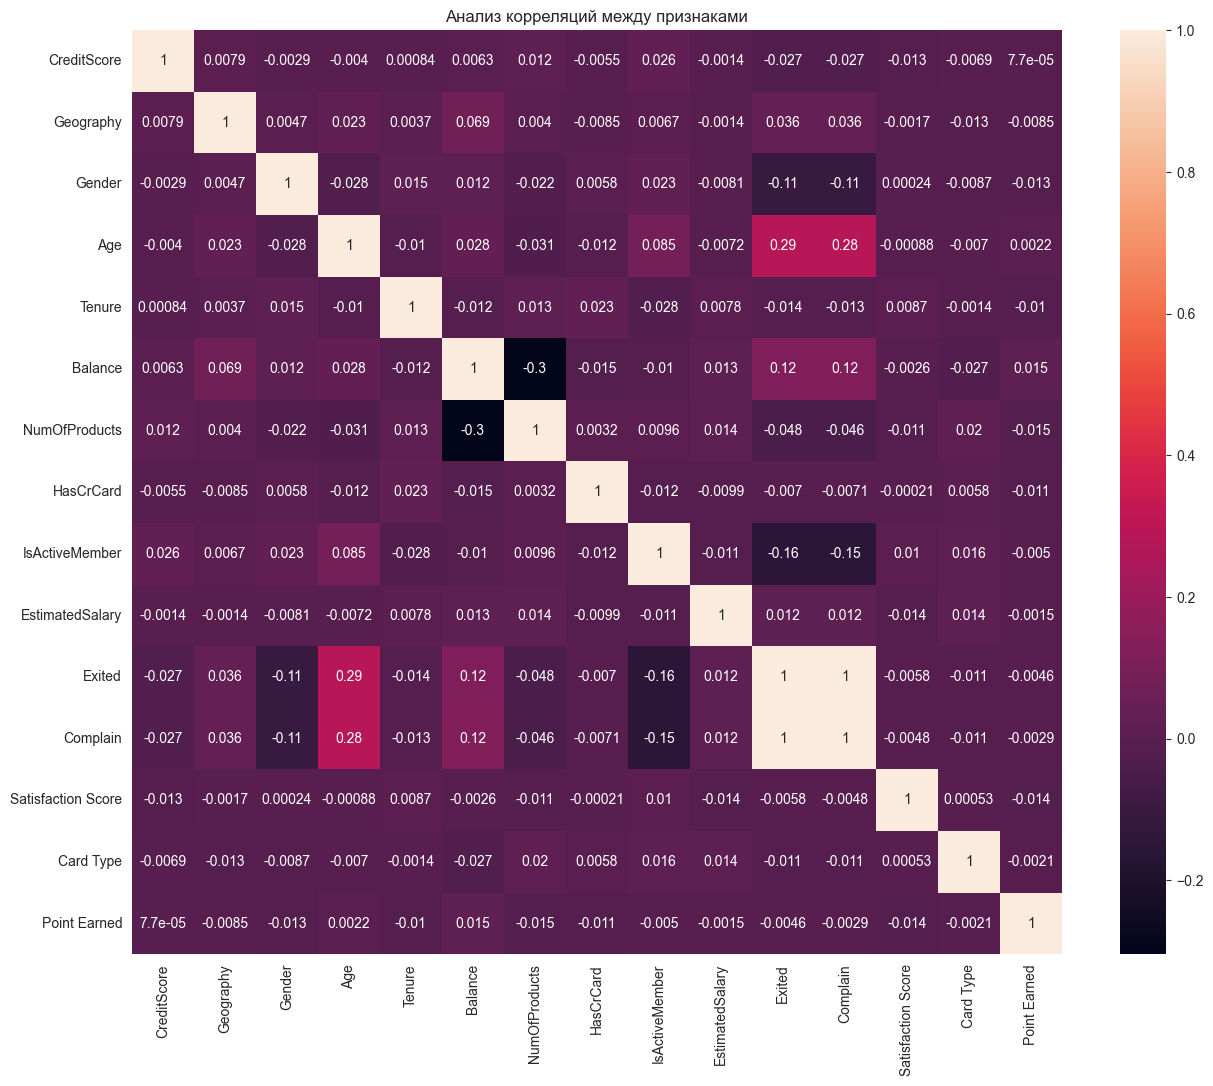

In [10]:
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), annot=True)
plt.title('Анализ корреляций между признаками')
plt.savefig('Correlation_heatmap.png')
plt.show()

##### Данная тепловая карта отображает матрицу корреляций Пирсона, которая позволяет выявить зависимости между признаками. Значения ближе к 1 и -1 указывают на сильную взаимосвязь, что помогает выявить ключевые факторы влияющие на целевой признак Exited
##### По данной карте можно увидеть что признаком имеющим наибольшее влияние является Complain (жалобы клиентов), что означает - факт наличия жалобы на 100% предопределяет отток клиента банка

### 2. Модель

##### Разделяю данные на признаки и целевую переменную

In [11]:
X1 = df.drop(columns=['Exited'], axis=1)
y1 = df['Exited']

##### Разделение данных на тренировочную и тестовую выборки

In [12]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=25)

#### Обучение модели Случайного леса
##### Данная модель была выбрана потому что прогнозирование оттока клиентов является задачей бинарной классификации (Да/Нет, Спам/Не спам и тд). Данная, модель устойчива к выбросам, не требует масштабирования данных и также эффективно работает с финансовыми данными. Модель позволяет оценить важность признаков

In [13]:
ch_modelv1 = RandomForestClassifier(n_estimators=25, random_state=42, max_depth=20, min_samples_split=8, min_samples_leaf=3)
ch_modelv1.fit(x_train1, y_train1)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",25
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",8
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",3
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

##### Предсказание на тестовой выборке

In [14]:
y_pred1 = ch_modelv1.predict(x_test1)

#### Оценка модели

In [15]:
accuracy1 = accuracy_score(y_test1, y_pred1)
print(f'Точность модели c колонкой Complain (Жалобы клиентов): {accuracy1*100:.2f}%')

roc_auc1 = roc_auc_score(y_test1, y_pred1)
print(f'ROC-AUC модели c колонкой Complain (Жалобы клиентов): {roc_auc1*100:.2f}%')

confusion_matrix1 = confusion_matrix(y_test1, y_pred1)
print('Матрица ошибок модели c колонкой Complain (Жалобы клиентов)')
print(confusion_matrix1)

Точность модели c колонкой Complain (Жалобы клиентов): 99.65%
ROC-AUC модели c колонкой Complain (Жалобы клиентов): 99.69%
Матрица ошибок модели c колонкой Complain (Жалобы клиентов)
[[1604    6]
 [   1  389]]


##### По матрице ошибок видно, что модель правильно предсказала 1604 клиента останутся, а 389 уйдут
##### Но модель так же допустила ошибку, что 6 уйдут, но они на самом деле остались и что 1 человек останется,
##### но ушел

##### Для эксперимента я попробую удалить колонку Complain - жалобы клиентов, так как модель думает,
##### что, если есть жалоба клиент точно уйдет, это можно увидеть по анализу корреляции между признаками
##### который я сделал раннее

##### Разделяю данные на признаки и целевую переменную

In [16]:
X2 = df.drop(columns=['Exited', 'Complain'], axis=1)
y2 = df['Exited']

##### Разделение данных на тренировочную и тестовую выборки

In [17]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=25)

##### Обучение модели

In [18]:
ch_modelv2 = RandomForestClassifier(n_estimators=25, random_state=42, max_depth=20, min_samples_split=8, min_samples_leaf=3)
ch_modelv2.fit(x_train2, y_train2)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",25
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",8
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",3
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

##### Предсказание на тестовой выборке

In [21]:
y_pred2 = ch_modelv2.predict(x_test2)

##### Оценка модели

In [20]:
accuracy2 = accuracy_score(y_test2, y_pred2)
print(f'Точность модели без колонки Complain (Жалобы клиентов): {accuracy2*100:.2f}%')

roc_auc2 = roc_auc_score(y_test2, y_pred2)
print(f'ROC-AUC модели без колонки Complain (Жалобы клиентов): {roc_auc2*100:.2f}%')

confusion_matrix2 = confusion_matrix(y_test2, y_pred2)
print('Матрица ошибок модели без колонки Complain (Жалобы клиентов)')
print(confusion_matrix2)

Точность модели без колонки Complain (Жалобы клиентов): 87.25%
ROC-AUC модели без колонки Complain (Жалобы клиентов): 70.81%
Матрица ошибок модели без колонки Complain (Жалобы клиентов)
[[1574   36]
 [ 219  171]]


#### Тут можно наблюдать меньше качества, но более реалистичные цифры,
#### так как колонка Complain имевшая большее
#### влияние в датасете удалена

#### Сравнительный анализ двух моделей

In [28]:
metrics_df = pd.DataFrame({
    'Параметр': ['Accuracy (Точность)', 'ROC-AUC Score'],
    'Модель v1 (с Complain)': [f"{accuracy1*100:.2f}%", f"{roc_auc1*100:.2f}"],
    'Модель v2 (без Complain)': [f"{accuracy2*100:.2f}%", f"{roc_auc2*100:.2f}"]
})

# Вывод
print("Сравнительная таблица метрик качества моделей:")
print(metrics_df)

Сравнительная таблица метрик качества моделей:
              Параметр Модель v1 (с Complain) Модель v2 (без Complain)
0  Accuracy (Точность)                 99.65%                   87.25%
1        ROC-AUC Score                  99.69                    70.81


#####  В ходе эксперимента были обучены две модели Случайного Леса для классификации (RandomForestClassifier)
##### Модель v1 продемонстрировала аномально высокую точность (близкую к 100%), причиной чего является признак Complain. Анализ показал, что данный признак является «предиктором-утечкой», так как в датасете каждая жалоба автоматически означает уход клиента, что можно было понять по визуализации анализа корреляций.
##### Модель v2 была обучена на очищенных данных без признака Complain, несмотря на снижения метрик, данная модель является более подходящей для практического применения

### 3. ТЕСТ

##### Новые данные о клиенте

In [22]:
new_customer_data = {
    'CreditScore': 650,
    'Geography': 'Germany',
    'Gender': 'Female',
    'Age': 42,
    'Tenure': 5,
    'Balance': 125000.50,
    'NumOfProducts': 2,
    'HasCrCard': 1,
    'IsActiveMember': 0,
    'EstimatedSalary': 50000.00,
    'Satisfaction Score': 3,
    'Card Type': 'GOLD',
    'Point Earned': 450
}

##### Делаю DataFrame

In [23]:
new_df = pd.DataFrame([new_customer_data])

#### Кодирую данные

In [25]:
new_df['Gender'] = le_gender.transform(new_df['Gender'])
new_df['Geography'] = le_geography.transform(new_df['Geography'])
new_df['Card Type'] = le_card_type.transform(new_df['Card Type'])

##### Предсказание на тестовой выборке

In [26]:
pred = ch_modelv2.predict(new_df)

prob = ch_modelv2.predict_proba(new_df)[:, 1] # Вероятность ухода
prob_churn = prob[0] * 100
prob_stay = prob[0] * 100

##### Вывод результата

In [27]:
if pred[0] == 1:
    print(f"Результат: Клиент скорее всего УЙДЕТ (Вероятность: {prob[0]*100:.2f}%)")
else:
    print(f"Результат: Клиент ОСТАНЕТСЯ (Вероятность ухода всего: {prob[0]*100:.2f}%)")

Результат: Клиент ОСТАНЕТСЯ (Вероятность ухода всего: 9.60%)


##### Сохраняю модель с помощью библиотеки joblib

In [ ]:
import joblib

joblib.dump(ch_modelv2, "bank_churn_model.pkl")
print("Модель сохранена в файл bank_churn_model.pkl")

joblib.dump(le_gender, 'le_gender.pkl')
joblib.dump(le_geography, 'le_geography.pkl')
joblib.dump(le_card_type, 'le_card_type.pkl')
print('Кодированные данные сохранены')

##### Для сайта/приложения/бота буду использовать вторую модель (ch_modelv2) с удаленной колонкой Complain засчет того что таким образом модель выдала более реалистичные результаты